# VAE for Topic Modeling

## Key Concepts:
1. `Encoder/Decoder`: The `VAE` architecture has an encoder that maps documents to a latent space and a decoder that attempts to reconstruct the input from the latent space.
2. `Latent Space`: The latent variables in the `VAE` can represent topics. By clustering or examining this space, topics can be discovered.
3. `Loss Function`: Combines reconstruction loss (how well the input is reconstructed) and KL divergence (encouraging the latent space to follow a normal distribution).  

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import math

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## Sample dataset: List of documents

In [5]:
data_words_bigrams = pd.read_pickle('scied_words_bigrams_V5.pkl')
documents_full = data_words_bigrams #taking first group of documents in our dataset

In [6]:
import gensim
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora.dictionary import Dictionary
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
 
# Take the first 10 documents
documents = data_words_bigrams  # Represents all words in the first 10 documents
 
# Gensim filtering
no_below = 15  # Keep tokens which are contained in at least 15 documents
no_above = 0.5  # Remove tokens that are contained in more than 50% of the documents
id2word = gensim.corpora.Dictionary(documents)
id2word.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000)
 
# Convert documents to Bag-of-Words representation
bow_corpus = [id2word.doc2bow(doc) for doc in documents]
 
# Prepare documents for CountVectorizer
documents = [" ".join(doc) for doc in documents]
 
# Generate Bag-of-Words matrix
vectorizer = CountVectorizer(max_features=1500)
X = vectorizer.fit_transform(documents).toarray()
 
# Normalize the BoW matrix using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_normalized = scaler.fit_transform(X)
 
# Check the shape of the normalized data
print(X_normalized.shape)

(5577, 1500)


In [7]:
X_normalized

array([[0.05555556, 0.45945946, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01587302, 0.02702703, 0.00869565, ..., 0.        , 0.        ,
        0.        ],
       [0.01587302, 0.02702703, 0.        , ..., 0.        , 0.00943396,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01639344]])

In [8]:
X = X_normalized
X_normalized.shape

(5577, 1500)

## Define Variational Autoencoder (VAE) architecture

In [10]:
#Architecture
#1. `Encoder/Decoder`: The `VAE` architecture has an encoder that maps documents to a latent space and a decoder that attempts to reconstruct the input from the latent space.
#2. `Latent Space`: The latent variables in the `VAE` can represent topics. By clustering or examining this space, topics can be discovered.
#3. `Loss Function`: Combines reconstruction loss (how well the input is reconstructed) and KL divergence (encouraging the latent space to follow a normal distribution).  

#`encode()`: The encoder splits the output into mean and logvar (log variance).
#`reparameterize()`: Instead of directly using the mean and log variance, this function samples from the Gaussian distribution defined by the mean and variance. The reason for this "reparameterization trick" is to allow backpropagation through the stochastic sampling process.
#`sample()`: Once trained, can call this functiion to use the decoder to generate new samples (e.g., new document representations) by sampling from the latent space.

class VAE(tf.keras.Model):
    def __init__(self, original_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder with careful initialization
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(original_dim,)),
            layers.Dense(512, 
                activation='relu', 
                kernel_initializer=tf.keras.initializers.HeNormal(),
                bias_initializer='zeros'),
            layers.Dense(256, 
                activation='relu', 
                kernel_initializer=tf.keras.initializers.HeNormal(),
                bias_initializer='zeros'),
            layers.Dense(latent_dim * 2,  
                kernel_initializer=tf.keras.initializers.GlorotNormal(),
                bias_initializer='zeros')
        ])
        
        # Decoder with careful initialization
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(256, 
                activation='relu', 
                kernel_initializer=tf.keras.initializers.HeNormal(),
                bias_initializer='zeros'),
            layers.Dense(512, 
                activation='relu', 
                kernel_initializer=tf.keras.initializers.HeNormal(),
                bias_initializer='zeros'),
            layers.Dense(original_dim, 
                #activation='sigmoid',  # Ensure output is between 0 and 1
                kernel_initializer=tf.keras.initializers.GlorotNormal(),
                bias_initializer='zeros')
        ])
        
    def encode(self, x):
        # Add numerical stability checks
        x = tf.cast(x, tf.float32)
        
        # Split output into mean and log variance
        z = self.encoder(x)
        mean, logvar = tf.split(z, num_or_size_splits=2, axis=1)
        
        # Clip log variance to prevent extreme values
        logvar = tf.clip_by_value(logvar, -10, 10)
        
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        # Stable reparameterization trick
        std = tf.exp(0.5 * logvar)
        eps = tf.random.normal(tf.shape(mean))
        return mean + std * eps
    
    def decode(self, z, apply_sigmoid=True):
        # Decode and optionally apply sigmoid
        logits = self.decoder(z)
        if apply_sigmoid:
            return tf.sigmoid(logits)
        return logits
    
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.decoder.input_shape[1]))
        return self.decode(eps)

## Compute loss


In [12]:
#The loss function in a VAE combines two parts:
#`Reconstruction loss`: This is the binary cross-entropy between the original input x and its reconstruction x_logit. It is summed across all dimensions (words) of the document.  
#`KL divergence`: This term encourages the latent variable distribution to stay close to a unit normal distribution (with mean 0 and variance 1). This helps regularize the model and ensure that the latent space is structured.  
#The final loss is the sum of the reconstruction loss and KL divergence, and we minimize this during training.

def kl_divergence_loss(mean, logvar):
    # Standard KL divergence loss between the learned distribution and standard normal
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return kl_loss

def compute_loss(model, x, beta=1.0):
    x = tf.clip_by_value(tf.cast(x, tf.float32), 1e-7, 1 - 1e-7)
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_recon = model.decode(z)
    
    # Reconstruction loss
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
        x_recon - x * tf.math.log(x_recon + 1e-7), axis=-1
    ))
    
    # KL divergence
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    
    # Total loss with adjustable beta
    total_loss = reconstruction_loss + beta * kl_loss
    return total_loss

## Set hyperparameters

In [14]:
# Training loop modifications
latent_dim = 20 #Latent dimensions to use
original_dim = X.shape[1] #Original shape of the input data
vae = VAE(original_dim, latent_dim) #Init VAE model

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)  #Setting the learning rate
epochs = 100  #Number of training epochs
batch_size = 32  #Batch size

C:\Users\JonBr\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


## Training the VAE model


Epoch 0, Training Loss: 130.4525, Holdout Loss: 109.1366
Epoch 1, Training Loss: 103.9040, Holdout Loss: 108.2533
Epoch 2, Training Loss: 102.7083, Holdout Loss: 106.7182
Epoch 3, Training Loss: 101.3899, Holdout Loss: 105.5197
Epoch 4, Training Loss: 99.9576, Holdout Loss: 104.6891
Epoch 5, Training Loss: 98.8991, Holdout Loss: 103.0861
Epoch 6, Training Loss: 97.9276, Holdout Loss: 102.3453
Epoch 7, Training Loss: 97.3673, Holdout Loss: 102.2091
Epoch 8, Training Loss: 96.9401, Holdout Loss: 101.6313
Epoch 9, Training Loss: 96.3136, Holdout Loss: 101.3676
Epoch 10, Training Loss: 96.0471, Holdout Loss: 101.7496
Epoch 11, Training Loss: 95.7356, Holdout Loss: 101.3799
Epoch 12, Training Loss: 95.5124, Holdout Loss: 100.9822
Epoch 13, Training Loss: 95.1047, Holdout Loss: 100.8661
Epoch 14, Training Loss: 94.9704, Holdout Loss: 101.3916
Epoch 15, Training Loss: 94.8327, Holdout Loss: 100.7619
Epoch 16, Training Loss: 94.4542, Holdout Loss: 101.0539
Epoch 17, Training Loss: 94.5307, Hol

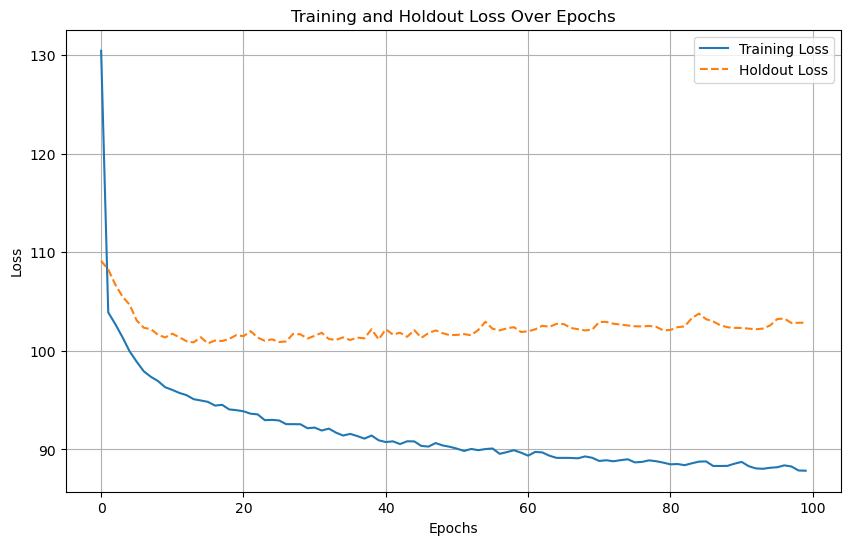

In [16]:
#* `Optimizer`: We use the Adam optimizer to minimize the loss function.

#* `Training Loop`: We loop over the data in batches (batch size 2 in this case) for a number of epochs. Inside the loop:

#A mini-batch of documents (x_batch) is fed into the VAE.
#The loss is computed using the compute_loss function.
#The gradients are calculated using TensorFlow’s GradientTape, and the model is updated accordingly.
#After each epoch, the current loss is printed out to track progress.

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the data into training and holdout sets
X_train, X_holdout = train_test_split(X, test_size=0.2, random_state=42)

# Initialize lists to store losses
training_losses = []
holdout_losses = []

# Training loop with holdout evaluation
for epoch in range(epochs):
    epoch_training_loss = 0.0
    # Training
    for i in range(0, len(X_train), batch_size):
        x_batch = X_train[i:i + batch_size]
        
        with tf.GradientTape() as tape:
            loss = compute_loss(vae, x_batch)
        
        gradients = tape.gradient(loss, vae.trainable_variables)
        gradients = [tf.clip_by_norm(g, 1.0) for g in gradients]
        optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
        
        epoch_training_loss += loss.numpy()
    
    # Average training loss
    avg_training_loss = epoch_training_loss / (len(X_train) // batch_size)
    training_losses.append(avg_training_loss)

    # Holdout evaluation
    holdout_loss = 0.0
    for i in range(0, len(X_holdout), batch_size):
        x_batch = X_holdout[i:i + batch_size]
        loss = compute_loss(vae, x_batch)
        holdout_loss += loss.numpy()
    
    # Average holdout loss
    avg_holdout_loss = holdout_loss / (len(X_holdout) // batch_size)
    holdout_losses.append(avg_holdout_loss)

    print(f"Epoch {epoch}, Training Loss: {avg_training_loss:.4f}, Holdout Loss: {avg_holdout_loss:.4f}")

# Plotting losses
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), training_losses, label='Training Loss')
plt.plot(range(epochs), holdout_losses, label='Holdout Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Holdout Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Interpreting the Latent Space
* The latent space can be used to represent topics  
* Can cluster the latent vectors to interpret the topics
* z represents the latent space, and clustering these latent representations will give groups of documents that share similar latent features, which can be interpreted as topics.

In [18]:
mean, logvar = vae.encode(X)
z = vae.reparameterize(mean, logvar)

# Steps to Visualize Documents by Topic:
1. Obtain Latent Vectors: After training the VAE, extract the latent vectors (z) for each document.
2. Assign Topics: Assign topics to documents by clustering the latent vectors.
3. Dimensionality Reduction: Use t-SNE or PCA to reduce the dimensionality of the latent vectors to 2D or 3D for visualization.
4. Plot: Use Matplotlib to plot the projections and color them by their assigned topics.

The visualization shows a scatter plot of documents mapped to a 2D latent space, where the colors represent different topic clusters as identified by the KMeans clustering algorithm. However, the plot alone doesn't tell us what the actual topics are in terms of words or themes.

To determine the topics, you need to inspect the original document vectors and see which words (or features) are most associated with each topic. There are a couple of ways to extract and interpret the topics:

1. Get the Top Words per Topic:
After clustering the documents, you can examine which words or features are most influential in each topic cluster by looking at the original word distributions for the documents assigned to each topic.

Approach:
Assign the topics to each document and, for each topic, sum the word counts across the documents assigned to that topic.

In [21]:
# `z` is the latent space representation of the documents

# Assign topics using KMeans clustering
num_topics = 23  # You can adjust this depending on how many topics you expect
kmeans = KMeans(n_clusters=num_topics, random_state=42)
topics = kmeans.fit_predict(z)

In [22]:
# `topics` are the cluster assignments for each document
# and `X` is the term-document matrix from CountVectorizer

# Get feature names (words) from the CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for easier analysis
df = pd.DataFrame(X, columns=feature_names)

# Add the topic assignments to the DataFrame
df['topic'] = topics

# Get top words for each topic by summing word counts for each topic
for topic in range(num_topics):
    print(f"Topic {topic}:")
    # Get all documents assigned to this topic
    topic_docs = df[df['topic'] == topic].drop(columns='topic')
    
    # Sum the word counts for this topic
    topic_word_sums = topic_docs.sum(axis=0).sort_values(ascending=False)
    
    # Display the top 10 words for the topic
    print(topic_word_sums.head(10))
    print()


Topic 0:
ing                  28.103448
necessary            25.647059
great                24.451613
elementary_school    21.775000
pro_gram             21.300000
develop              20.740000
available            18.642857
science              18.129573
definite             18.000000
certain              17.964286
dtype: float64

Topic 1:
education_john    32.111111
wiley_son         31.333333
significant       31.187500
result            29.333333
test              29.120930
administer        24.777778
mean              24.439024
study             24.353659
determine         24.138889
table             22.903846
dtype: float64

Topic 2:
number      27.145161
science     26.379573
great       25.548387
table       21.576923
study       19.764228
teacher     19.043764
percent     18.858974
total       18.826923
teach_er    18.000000
ing         17.620690
dtype: float64

Topic 3:
wiley_periodical    73.500000
develop             41.060000
way                 38.727273
student         

In [23]:
df['topic'].value_counts()

topic
1     355
10    308
6     303
22    299
0     299
8     293
15    269
7     269
13    268
21    267
5     253
18    238
2     237
20    229
19    220
9     215
11    211
17    196
12    184
16    179
4     172
14    168
3     145
Name: count, dtype: int64

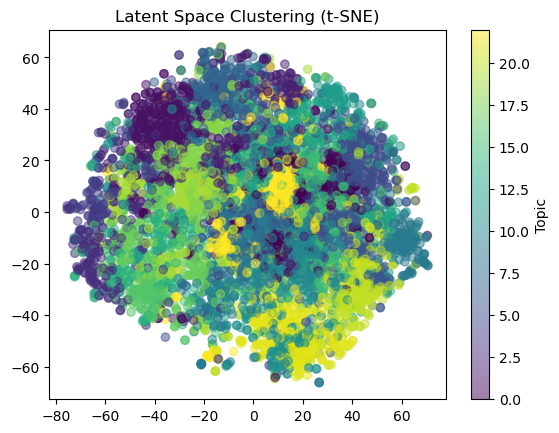

In [24]:
# If `latent_dim` is 2 (for easier visualization in 2D), we skip t-SNE.
# If latent_dim > 2, you can uncomment t-SNE for dimensionality reduction.

import matplotlib.pyplot as plt

if z.shape[1] == 2:
    plt.scatter(z[:, 0], z[:, 1], c=topics, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Topic')
    plt.title('Latent Space Clustering')
    plt.show()
else:
    from sklearn.manifold import TSNE
    z_2d = TSNE(n_components=2, random_state=42).fit_transform(z)
    plt.scatter(z_2d[:, 0], z_2d[:, 1], c=topics, cmap='viridis', alpha=0.5)
    plt.colorbar(label='Topic')
    plt.title('Latent Space Clustering (t-SNE)')
    plt.show()

# VAE Coherence

In [26]:
tokenized_documents = [doc.split() for doc in documents]  # Assuming `documents` is a list of strings

In [27]:
topics_list = []  # List to hold top words for each topic

for topic in range(num_topics):
    topic_docs = df[df['topic'] == topic].drop(columns='topic')  # Filter docs by topic
    topic_word_sums = topic_docs.sum(axis=0).sort_values(ascending=False)  # Sum word counts
    top_words = topic_word_sums.head(10).index.tolist()  # Get top 10 words for this topic
    topics_list.append(top_words)  # Add to topics list


In [28]:
#from gensim.corpora import Dictionary
dictionary = Dictionary(tokenized_documents)

In [29]:
from gensim.models import CoherenceModel

coherence_model = CoherenceModel(
    topics=topics_list,
    texts=tokenized_documents,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")


Coherence Score: 0.40251880916955407
